# Differential Phase Shift QKD protocol Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import math
from ThOPqkdsim.simDPS import DPSQKDSimulator

<div style="text-align: center;">
    <img src="Figures/DPS/dps_fig.png" width="800">
</div>

## Introduction to QKD

Quantum Key Distribution (QKD) allows two parties (commonly called Alice and Bob) to generate a shared, secret random key, secure against any eavesdropping attempts, thanks to the laws of quantum physics.

## DPS-QKD Protocol Overview

**Differential Phase Shift (DPS) QKD** encodes information in the phase difference between consecutive coherent light pulses.

- Alice sends a train of weak coherent pulses with random phase modulations.
- Bob uses an interferometer to measure the phase differences and extract the key.
- Security is based on the inability of an eavesdropper (Eve) to perfectly distinguish the phase differences without disturbing the quantum states.

### Key Parameters

- Mean photon number per pulse ($\mu$)
- Channel transmittance ($\eta_{ch}$)
- Detector efficiency ($\eta_{det}$)
- Dark count probability ($p_{dark}$)
- Bit error rate ($e_{bit}$)
- Fiber loss coefficient ($\alpha$)
- Distance ($d$)

---

<div style="text-align: center;">
    <img src="Figures/DPS/QKD_sim-DPSqkd-steps.png" width="800">
</div>

## Differential Phase Shift (DPS) QKD Simulator

### Overview

The `DPSQKDSimulator` class implements a simulation of the Differential Phase Shift Quantum Key Distribution protocol. DPS QKD is a protocol where Alice sends a train of coherent pulses with randomly modulated phases (0 or π), and Bob measures the phase difference between adjacent pulses using an unbalanced Mach-Zehnder interferometer.

### Class Parameters

#### Protocol Parameters
- `nem`: Number of blocks sent by Alice (default: 10^6)
- `repetition_rate`: Pulse repetition rate in Hz (default: 1 GHz)
- `mu`: Mean photon number per pulse (default: 0.1)
- `t_prob`: Probability for code event selection (default: 0.5)

#### Error Model Parameters
- `ebit`: Bit error rate (default: 0.01 or 1%)
- `dark_count`: Dark count probability per detection window (default: 10^-7)

#### Detector Parameters
- `eta_det`: Detector efficiency (default: 0.1 or 10%)

#### Channel Parameters
- `distance`: Channel distance in kilometers (default: 50 km)
- `alpha`: Fiber attenuation coefficient in dB/km (default: 0.2 dB/km)
- `channel_mode`: Type of channel - "fiber" or "fso"
- `base_efficiency`: Base channel efficiency without distance effects (default: 1.0)

#### FSO-Specific Parameters
- `transmitter_diameter`: Diameter of transmitter aperture in meters (default: 0.1m)
- `receiver_diameter`: Diameter of receiver aperture in meters (default: 0.3m)
- `beam_divergence`: Beam divergence angle in radians (default: 0.001 rad or 1 mrad)
- `misalignment_base`: Base misalignment error (default: 1.5%)
- `misalignment_factor`: Increase in misalignment per km (default: 0.0002)

#### Interferometer Parameters
- `delta_bs1`: BS1 transmittance deviation from ideal 50% (default: 0.005)
- `delta_bs2`: BS2 transmittance deviation from ideal 50% (default: 0.005)

### Derived Parameters

- `eta_ch`: Channel transmittance (calculated based on distance and channel mode)
- `eta`: Overall transmittance (product of channel transmittance and detector efficiency)
- `eta1_L`, `eta1_U`: Lower and upper bounds of BS1 transmittance
- `eta2_L`, `eta2_U`: Lower and upper bounds of BS2 transmittance
- `lambda_factor`: Security parameter calculated from beamsplitter parameters

### Channel Efficiency Models

#### Fiber Channel Efficiency
For fiber optic channels, the efficiency follows the standard exponential attenuation model:

$$\eta_{ch}^{fiber} = 10^{-\frac{\alpha \cdot d}{10}}$$

Where:
- $\alpha$ is the fiber attenuation coefficient in dB/km
- $d$ is the distance in kilometers

#### FSO Channel Efficiency
For free-space optical channels, the efficiency is modeled as:

$$\eta_{ch}^{FSO} = G_{geo} \cdot \eta_{atm}$$

Where:
- $G_{geo}$ is the geometrical loss factor due to beam spreading
- $\eta_{atm}$ is the transmitter optical efficiency


In [2]:
class DPSQKD:
    """
    Simulator for Differential Phase Shift (DPS) Quantum Key Distribution protocol.
    Supports both fiber and free-space optical (FSO) channels.
    """
    def __init__(self, 
                 nem=10**6,              # Number of blocks sent by Alice
                 repetition_rate=1e9,    # Pulse repetition rate (Hz)
                 mu=0.1,                 # Mean photon number per pulse
                 ebit=0.01,              # Bit error rate
                 eta_det=0.1,            # Detector efficiency
                 dark_count=1e-7,        # Dark count probability per detection window
                 alpha=0.2,              # Fiber loss coefficient (dB/km)
                 distance=50,            # Channel distance (km)
                 delta_bs1=0.005,        # BS1 transmittance deviation from ideal 50%
                 delta_bs2=0.005,        # BS2 transmittance deviation from ideal 50%
                 t_prob=0.5,             # Probability for code event selection
                 channel_mode="fiber",   # Channel mode: "fiber" or "fso"
                 # FSO parameters (used only if channel_mode is "fso")
                 transmitter_diameter=0.1,   # Diameter of transmitter aperture in meters
                 receiver_diameter=0.3,      # Diameter of receiver aperture in meters
                 beam_divergence=0.001,      # Beam divergence angle in radians
                 wavelength=850e-9,          # Wavelength in meters
                 pointing_error=1e-6,        # Pointing error in radians
                 transmitter_efficiency=0.9, # Efficiency of transmitter optics
                 receiver_efficiency=0.9):   # Efficiency of receiver optics
        """
        Initialize the DPS QKD simulator with given parameters.
        """
        self.nem = nem                   # Number of total blocks sent by Alice
        self.repetition_rate = repetition_rate  # Pulse repetition rate in Hz
        self.mu = mu                     # Mean photon number per pulse
        self.ebit = ebit                 # Bit error rate
        self.eta_det = eta_det           # Detector efficiency
        self.dark_count = dark_count     # Dark count probability
        self.alpha = alpha               # Fiber loss coefficient (dB/km)
        self.distance = distance         # Channel distance (km)
        self.delta_bs1 = delta_bs1       # BS1 transmittance deviation
        self.delta_bs2 = delta_bs2       # BS2 transmittance deviation
        self.t_prob = t_prob             # Probability for code event selection
        
        # Channel parameters
        self.channel_mode = channel_mode
        # Base efficiency without distance (typically 1.0 for ideal conditions)
        self.base_efficiency = 1.0
        
        # FSO specific parameters
        self.transmitter_diameter = transmitter_diameter
        self.receiver_diameter = receiver_diameter
        self.beam_divergence = beam_divergence
        self.wavelength = wavelength
        self.pointing_error = pointing_error
        self.transmitter_efficiency = transmitter_efficiency
        self.receiver_efficiency = receiver_efficiency
        self.misalignment_base = 0.015    # 1.5% base misalignment error
        self.misalignment_factor = 0.0002 # Increase per km
        
        # Calculate derived parameters
        self.eta_ch = self._calculate_channel_efficiency()  # Channel transmittance
        self.eta = self.eta_ch * self.eta_det               # Overall transmittance
        
        # BS transmittance ranges
        self.eta1_L = 0.5 - self.delta_bs1
        self.eta1_U = 0.5 + self.delta_bs1
        self.eta2_L = 0.5 - self.delta_bs2
        self.eta2_U = 0.5 + self.delta_bs2
        
        # Use upper bounds for security analysis
        self.eta1 = self.eta1_U
        self.eta2 = self.eta2_U
        # Calculate lambda(eta1_U, eta2_U) according to equation (16)
        self.lambda_factor = self._calculate_lambda(self.eta1, self.eta2)

In [3]:
def _calculate_channel_efficiency(self):
    """
    Calculate the channel efficiency based on the selected mode (fiber or FSO).
    
    Returns:
        float: Channel transmission efficiency
    """
    if self.channel_mode == "fiber":
        return self._calculate_fiber_efficiency()
    elif self.channel_mode == "fso":
        return self._calculate_fso_efficiency()
    else:
        raise ValueError(f"Unknown channel mode: {self.channel_mode}")

def _calculate_fiber_efficiency(self):
    """
    Calculate efficiency for fiber optic channel.
    
    Returns:
        float: Channel efficiency for fiber
    """
    # Calculate attenuation in dB
    attenuation_db = self.distance * self.alpha
    
    # Convert to transmission efficiency: 10^(-attenuation_db/10)
    distance_factor = 10**(-attenuation_db/10)
    
    # Total efficiency is base efficiency times distance factor
    return self.base_efficiency * distance_factor

def _calculate_fso_efficiency(self):
    """
    Calculate efficiency for FSO channel based on provided model.
    
    Returns:
        float: Channel efficiency for FSO
    """
    # For zero distance, return direct efficiency without atmospheric effects
    if self.distance <= 1e-6:  # Effectively zero
        return self.base_efficiency * self.transmitter_efficiency * self.receiver_efficiency

    # Calculate geometrical loss factor
    beam_diameter_at_receiver = self.transmitter_diameter + (self.distance * 1000 * self.beam_divergence)
    geo_factor = min(1.0, (self.receiver_diameter / beam_diameter_at_receiver)**2)
    
    # Calculate simplified turbulence-induced scintillation loss
    # Using a simplified model based on distance
    turb_factor = np.exp(-0.05 * self.distance)  # Simplified exponential decay with distance
    
    # Calculate simplified beam wandering effect
    # Increases with distance
    pointing_variance = (self.pointing_error * self.distance * 1000)**2
    beam_spot_size = (self.beam_divergence * self.distance * 1000 / 2)**2
    bw_factor = np.exp(-2 * pointing_variance / beam_spot_size)
    
    # Calculate overall transmission efficiency
    total_efficiency = (self.base_efficiency * geo_factor * self.transmitter_efficiency * 
                        self.receiver_efficiency * turb_factor * bw_factor)
    
    return min(1.0, max(0.0, total_efficiency))  # Ensure efficiency is between 0 and 1

def calculate_misalignment_error(self):
    """
    Calculate optical misalignment error based on distance.
    
    Returns:
        float: Misalignment error probability (0-1)
    """
    # Error increases with distance but saturates
    return min(0.1, self.misalignment_base + self.misalignment_factor * self.distance)

def update_distance(self, distance):
    """
    Update the channel distance and recalculate all dependent parameters.
    
    Args:
        distance (float): New channel distance in kilometers
    """
    self.distance = distance
    self.eta_ch = self._calculate_channel_efficiency()
    self.eta = self.eta_ch * self.eta_det
    
def update_channel_mode(self, mode):
    """
    Update the channel mode and recalculate efficiency.
    
    Args:
        mode (str): New channel mode ("fiber" or "fso")
    """
    if mode not in ["fiber", "fso"]:
        raise ValueError(f"Unsupported channel mode: {mode}. Use 'fiber' or 'fso'.")
        
    self.channel_mode = mode
    self.eta_ch = self._calculate_channel_efficiency()
    self.eta = self.eta_ch * self.eta_det

def set_fso_parameters(self, transmitter_diameter=None, receiver_diameter=None, 
                        beam_divergence=None, wavelength=None, pointing_error=None,
                        transmitter_efficiency=None, receiver_efficiency=None):
    """
    Update FSO-specific parameters. Only updates the parameters that are provided.
    
    Args:
        transmitter_diameter (float, optional): Diameter of transmitter aperture in meters
        receiver_diameter (float, optional): Diameter of receiver aperture in meters
        beam_divergence (float, optional): Beam divergence angle in radians
        wavelength (float, optional): Wavelength in meters
        pointing_error (float, optional): Pointing error in radians
        transmitter_efficiency (float, optional): Efficiency of transmitter optics
        receiver_efficiency (float, optional): Efficiency of receiver optics
    """
    if transmitter_diameter is not None:
        self.transmitter_diameter = transmitter_diameter
    if receiver_diameter is not None:
        self.receiver_diameter = receiver_diameter
    if beam_divergence is not None:
        self.beam_divergence = beam_divergence
    if wavelength is not None:
        self.wavelength = wavelength
    if pointing_error is not None:
        self.pointing_error = pointing_error
    if transmitter_efficiency is not None:
        self.transmitter_efficiency = transmitter_efficiency
    if receiver_efficiency is not None:
        self.receiver_efficiency = receiver_efficiency
        
    # Recalculate efficiency if in FSO mode
    if self.channel_mode == "fso":
        self.eta_ch = self._calculate_channel_efficiency()
        self.eta = self.eta_ch * self.eta_det

### Key Functions and Mathematical Background

#### 1. Poisson Probability

For a mean $\lambda$, the probability of $k$ photons:
$$
P(k; \lambda) = \frac{e^{-\lambda} \lambda^k}{k!}
$$

In [4]:
def _calculate_lambda(self, eta1, eta2):
        """
        Calculate the lambda factor according to equation (16) in the paper.
        """
        term1 = 1 - (1 - eta1) * eta2
        term2 = np.sqrt((term1)**2 - 4 * eta1 * (1 - eta1) * (1 - eta2)**2)
        numerator = term1 + term2
        denominator = 2 * (1 - eta1) * (1 - eta2)**2
        return numerator / denominator
    
def _calculate_poisson_prob(self, k, mean):
    """
    Calculate Poisson probability mass function for exactly k events with given mean.
    """
    return np.exp(-mean) * (mean ** k) / math.factorial(k)

def _calculate_qn(self, n, mu=None):
    """
    Calculate qn, the probability of emitting exactly n photons in the block.
    """
    if mu is None:
        mu = self.mu
        
    # Each block has 3 pulses with mean photon number mu per pulse
    total_mu = 3 * mu
    return self._calculate_poisson_prob(n, total_mu)

#### 2. Gain and Yield Calculations

- **Yield for $n$ photons:**
  - Vacuum ($n=0$): $Y_0 = p_{dark}$
  - $n > 0$: $Y_n = 1 - (1 - \eta)^n$
- **Gain:**
  $$
  Q = \sum_{n=0}^{n_{max}} P(n) \cdot Y_n
  $$

In [5]:
def _calculate_yields_and_gains(self, mu=None, eta=None):
        """
        Calculate yields and gains for different photon number components.
        Based on GLLP security analysis framework.
        """
        if mu is None:
            mu = self.mu
        
        if eta is None:
            eta = self.eta
            
        # Calculate yields (conditional detection probabilities) for different photon numbers
        Y = {}
        for n in range(6):  # Consider up to 5 photons (sufficient for typical μ values)
            if n == 0:
                # Vacuum yield is just the dark count rate
                Y[n] = self.dark_count
            else:
                # n-photon yield is the probability of at least one photon being detected
                Y[n] = 1 - (1 - eta)**n
        
        # Calculate gain for each photon number component
        gain = {}
        total_gain = 0
        block_mu = 3 * mu  # For a 3-pulse block
        
        for n in range(6):
            # Probability of emitting n photons * yield of n-photon states
            p_n = self._calculate_poisson_prob(n, block_mu)
            gain[n] = p_n * Y[n]
            total_gain += gain[n]
        
        return Y, gain, total_gain

#### 3. Phase Error Rate (GLLP Framework)

- **Vacuum:** $e_{vacuum} = 0.5$
- **Single-photon:** $e_{single} = e_{bit}$
- **Multi-photon:** $e_{multi} = 0.5$ (worst case)

Weighted sum:
$$
e_{phase} = \frac{Q_0 e_{vacuum} + Q_1 e_{single} + \sum_{n \geq 2} Q_n e_{multi}}{Q_{total}}
$$

#### 4. Secret Key Rate ($R$)

- **Shannon entropy:**
  $$
  h(p) = -p\log_2 p - (1-p)\log_2(1-p)
  $$
- **Key length per block:**
  $$
  \ell = N_{code} - N_{EC} - N_{PA}
  $$
  - $N_{code}$: Number of code events
  - $N_{EC}$: Cost of error correction
  - $N_{PA}$: Privacy amplification cost

- **Secret key rate:**
  $$
  R = \frac{\ell}{N_{pulses}}
  $$
- **Final SKR (bits/s):**
  $$
  R_{bps} = R \cdot f_{rep}
  $$

In [6]:
def _calculate_phase_error_rate(self, gain, mu=None):
    """
    Calculate upper bound on phase error rate using proper security proof.
    """
    if mu is None:
        mu = self.mu
        
    # QBER for single-photon component
    e1 = self.ebit
    
    # Phase error rate contribution from different sources
    e_vacuum = 0.5  # Vacuum contribution (random)
    e_single = e1   # Single-photon contribution
    e_multi = 0.5   # Multi-photon contribution (worst case)
    
    # Overall phase error rate with proper weighting
    total_gain = sum(gain.values())
    if total_gain > 0:
        e_phase = (gain[0] * e_vacuum + gain[1] * e_single + 
                    sum([gain[n] * e_multi for n in range(2, 6)])) / total_gain
    else:
        e_phase = 0.5
        
    return e_phase
    
def calculate_secret_key_rate(self, mu=None):
    """
    Unified secret key rate calculation that works for both mu and distance analysis.
    Based on rigorous GLLP security analysis for weak coherent pulse QKD.
    """
    if mu is None:
        mu = self.mu
        eta = self.eta
    else:
        # If mu is explicitly provided, we keep the current eta (distance)
        eta = self.eta
    
    # Calculate yields and gains
    Y, gain, Q_gllp = self._calculate_yields_and_gains(mu, eta)
    
    # Phase error rate based on GLLP analysis
    e_phase = self._calculate_phase_error_rate(gain, mu)
    
    # For compatibility with the original distance behavior,
    # we also calculate Q using the original formula
    Q_original = 2 * eta * mu * np.exp(-2 * eta * mu)
    
    # Blend the two models with a weighting that depends on whether we're
    # analyzing mu or distance dependency
    # For mu analysis (bell curve), we want GLLP to dominate
    # For distance analysis, we want original formula to dominate
    # We can determine this by checking if mu was explicitly provided
    
    # Calculate correction factor based on distance to favor original formula
    # as distance increases
    distance_factor = min(1.0, self.distance / 100)
    
    if mu == self.mu:  # distance analysis (no explicit mu provided)
        # Use a blend that favors the original formula
        Q = Q_original
        
        # Calculate upper bound on phase error rate according to original equation (15)
        q1 = self._calculate_qn(1, mu)
        q2 = self._calculate_qn(2, mu)
        q3 = self._calculate_qn(3, mu)
        e_U_ph = (self.lambda_factor * (self.ebit + np.sqrt(q1 * q3) / Q + 2 * self.delta_bs2) 
                    + q2 / Q)
        
        # Number of code events
        Ncode = self.t_prob * self.nem * Q
        
        # Cost of error correction - based on Shannon limit
        NEC = Ncode * self._shannon_entropy(self.ebit)
        
        # Amount of privacy amplification
        NPA = Ncode * self._shannon_entropy(e_U_ph)
        
        # Secret key length
        ell = Ncode - NPA - NEC
        
        # Secret key rate per emitted pulse
        R = ell / (3 * self.nem)
        
    else:  # mu analysis (explicit mu provided)
        # For mu analysis, use GLLP framework
        Q = Q_gllp
        
        # Calculate single-photon and multi-photon contributions
        p1 = self._calculate_qn(1, mu)
        Y1 = Y[1]
        
        # Calculate secret fraction based on GLLP security analysis
        r = max(0, gain[1]/Q * (1 - self._shannon_entropy(e_phase)) - 
                self._shannon_entropy(self.ebit))
        
        # Final key rate (bits per pulse)
        R = r * Q
    
    # Convert to bits per second
    R_bps = R * self.repetition_rate
    
    return max(0, R_bps)

#### 5. QBER Calculation

QBER includes both signal and noise contributions:
$$
QBER = \frac{0.5 \cdot p_{dark} + e_{bit} \cdot P_{signal} + 0.25 \cdot P_{multi} \cdot \eta}{P_{signal} + p_{dark}}
$$

In [7]:
def _shannon_entropy(self, p):
    """
    Shannon entropy function h(p) = -p*log2(p) - (1-p)*log2(1-p)
    """
    if p <= 0 or p >= 1:
        return 0
    return -p * np.log2(p) - (1-p) * np.log2(1-p)


def calculate_qber(self):
    """
    Calculate the expected QBER based on dark counts and signal.
    """
    # Signal detection probability
    signal_prob = self.eta * self.mu * np.exp(-self.mu)  # Changed formula

    # Multi-photon contribution that increases with higher mu
    multi_photon_error = 1 - np.exp(-self.mu) - self.mu * np.exp(-self.mu)

    # Noise due to dark counts
    noise_prob = self.dark_count

    # Base error rate from imperfect interference
    base_error = self.ebit

    # QBER calculation with multi-photon contribution that increases with μ
    if signal_prob + noise_prob > 0:
        # Add a term that increases with mu to get increasing QBER
        qber = (0.5 * noise_prob + base_error * signal_prob + 
                0.25 * multi_photon_error * self.eta) / (signal_prob + noise_prob)
    else:
        qber = 0.5  # No signal, only random noise
        
    return qber

# QBER Calculation

<div style="text-align: center;">
    <img src="Figures/DPS/QKD_sim-Copy of DPSqkd-qber.png" width="700">
</div>

# SKR Calculation

<div style="text-align: center;">
    <img src="Figures/DPS/QKD_sim-DPSqkd-skr.png" width="1000">
</div>

<a name="plotting"></a>
# **Plotting and Results Visualization**

The module provides functions to visualize QBER and SKR as a function of mean photon number $\mu$ and channel distance $d$.

In [11]:
def run_cow_qkd_simulation_fiber():
    sim = DPSQKDSimulator(
        nem=10**6,               # Number of blocks sent
        repetition_rate=1e9,     # 1 GHz repetition rate
        mu=0.1,                  # Mean photon number
        ebit=0.01,               # Bit error rate
        eta_det=0.1,             # Detector efficiency
        dark_count=1e-7,         # Dark count probability
        alpha=0.2,               # Fiber loss (dB/km)
        distance=50,             # Distance in km
        delta_bs1=0.005,         # BS1 deviation
        delta_bs2=0.005,         # BS2 deviation
        t_prob=0.5,               # Probability for code event
        channel_mode='fiber'      # Channel mode
    )

    # Print simulation summary
    sim.plot_qber_vs_mu()
    sim.plot_qber_vs_distance()
    sim.plot_skr_vs_mu(mu_range=(0.001, 0.5))  
    sim.plot_skr_vs_distance(distance_range=(0, 400))


    plt.show()

def run_cow_qkd_simulation_fso():
    sim = DPSQKDSimulator(
        nem=10**6,               # Number of blocks sent
        repetition_rate=1e9,     # 1 GHz repetition rate
        mu=0.1,                  # Mean photon number
        ebit=0.01,               # Bit error rate
        eta_det=0.1,             # Detector efficiency
        dark_count=1e-7,         # Dark count probability
        alpha=0.2,               # Fiber loss (dB/km)
        distance=2,             # Distance in km
        delta_bs1=0.005,         # BS1 deviation
        delta_bs2=0.005,         # BS2 deviation
        t_prob=0.5,               # Probability for code event
        channel_mode='fso'      # Channel mode
    )

    # Print simulation summary
    sim.plot_qber_vs_mu()
    sim.plot_qber_vs_distance()
    sim.plot_skr_vs_mu(mu_range=(0.001, 0.5))  
    sim.plot_skr_vs_distance(distance_range=(0, 200))


    plt.show()

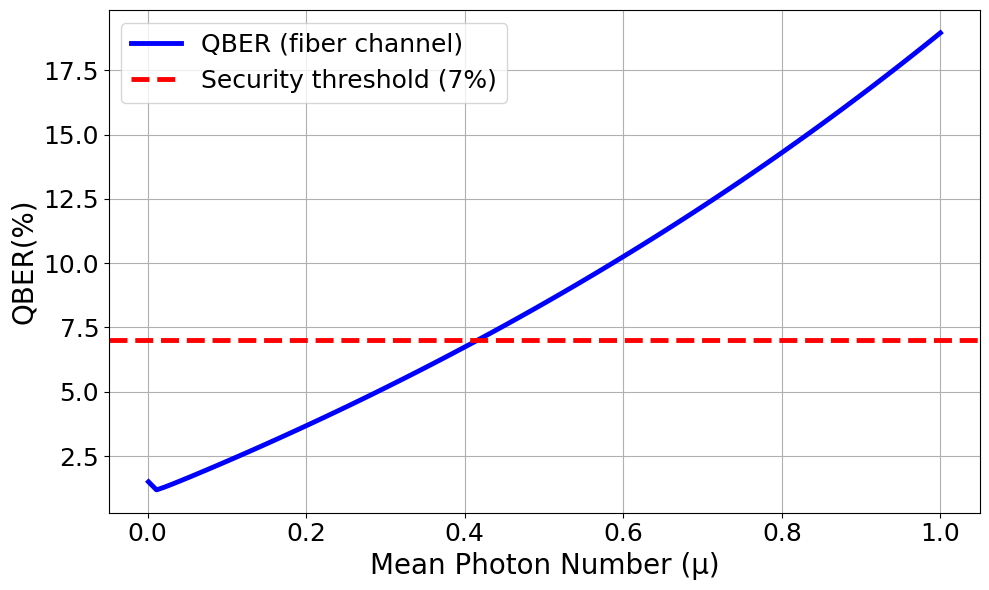

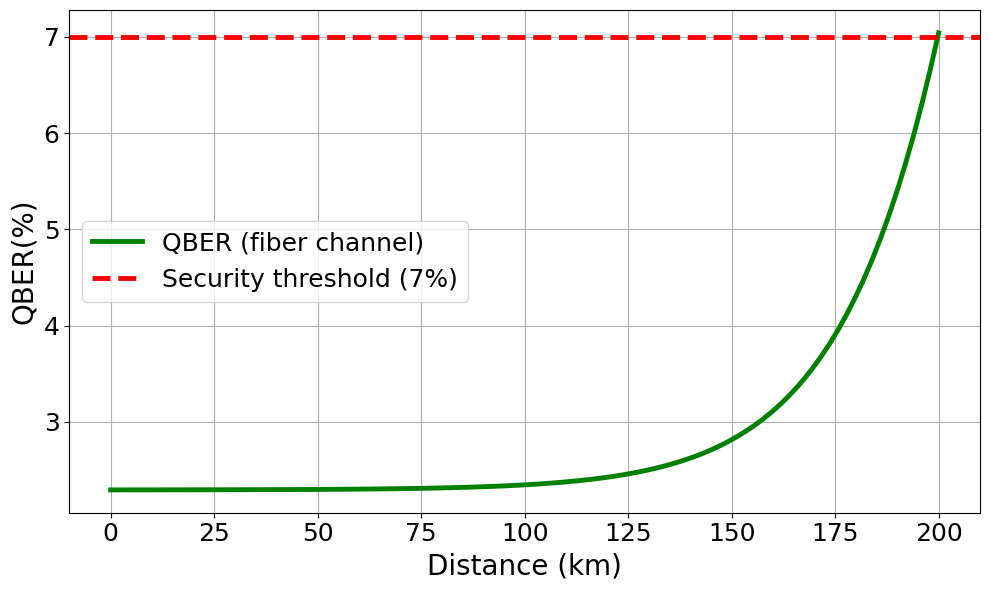

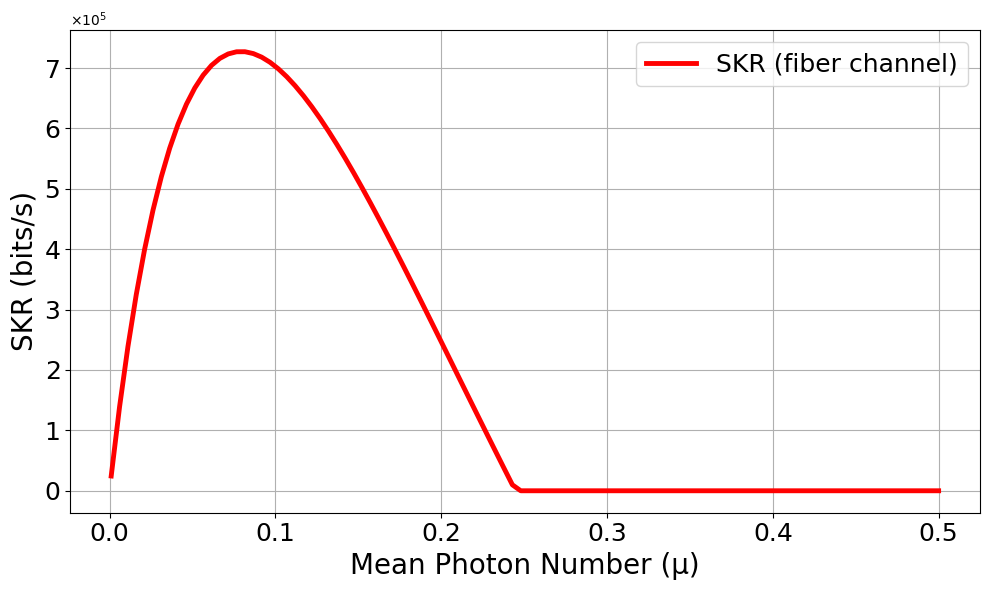

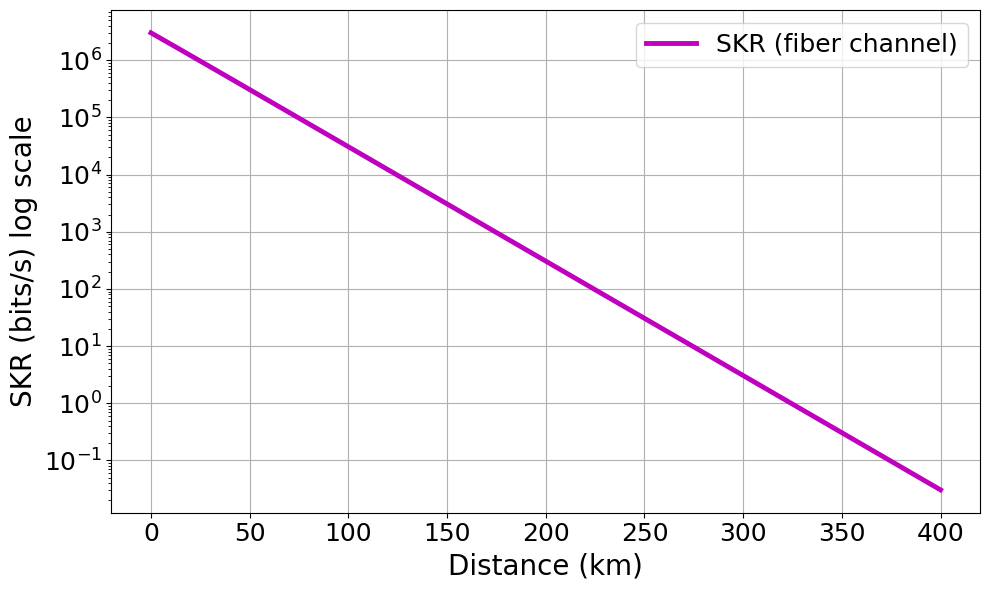

In [12]:
run_cow_qkd_simulation_fiber()

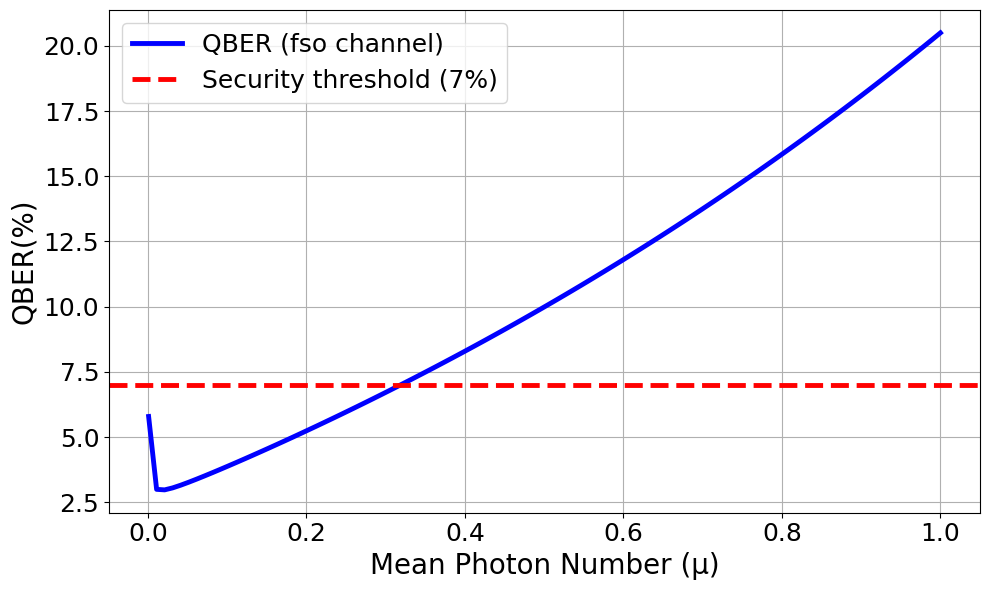

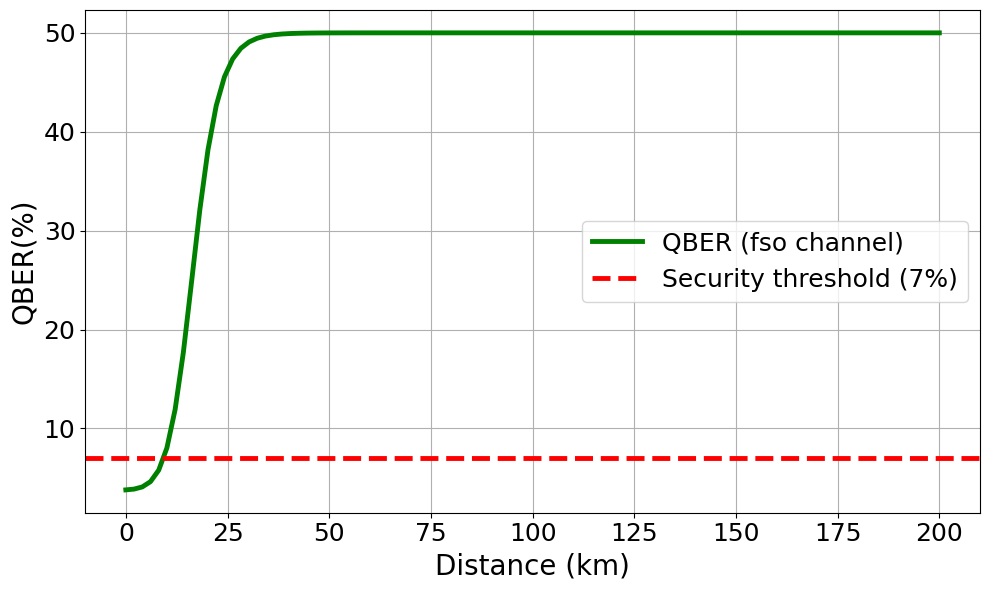

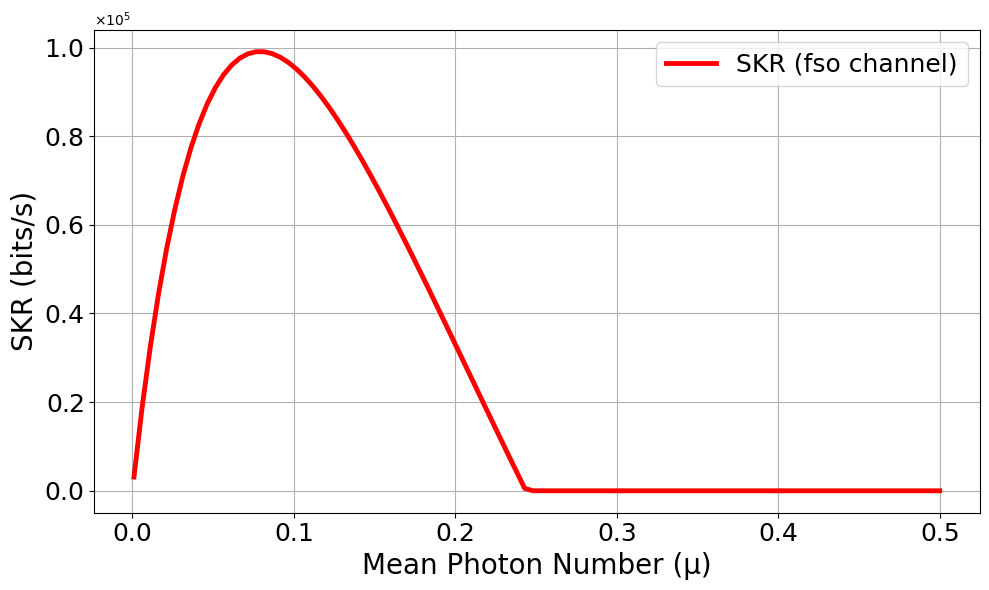

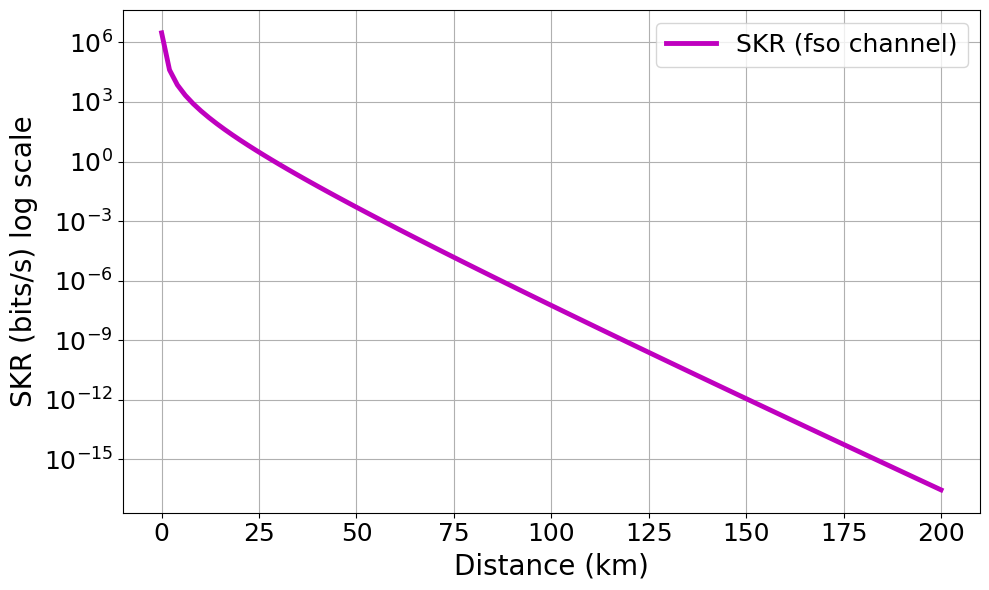

In [13]:
run_cow_qkd_simulation_fso()

## Conclusion: Differential Phase Shift (DPS) QKD Simulator

The **Differential Phase Shift (DPS) QKD Simulator** presented in this module provides an accessible yet rigorous framework for exploring the performance and security of DPS-based quantum key distribution systems. By encapsulating both the fundamental physics and the practical engineering parameters—such as mean photon number, detector efficiency, channel loss, and dark counts—the simulator enables users to:

- **Visualize and analyze** how the secret key rate (SKR) and quantum bit error rate (QBER) depend on both the mean photon number and the transmission distance.
- **Apply security proofs** (GLLP and original DPS-specific formulas) to obtain realistic bounds on key rates.
- **Optimize protocol parameters** (e.g., mean photon number) for maximal secure throughput.
- **Demonstrate trade-offs** inherent in real-world QKD deployments, such as the impact of increasing channel loss or detector imperfections.

Through interactive plotting and parameter adjustments, users can gain intuition about the operational regime of DPS-QKD, making this simulator a useful tool for both education and protocol research.

---

## Future Work

While the current simulator offers a comprehensive platform for DPS-QKD analysis, several avenues remain open for enhancement and further research:

1. **Integration of Advanced Attack Models:**  
   Extend the simulator to include explicit modeling of eavesdropping strategies (e.g., photon number splitting attacks, optimal quantum cloning), and simulate countermeasures such as decoy states.

2. **Finite-Key Effects:**  
   Incorporate finite-key analysis, accounting for statistical fluctuations in realistic, finite-length key exchanges, which are critical for practical deployments.

3. **Experimental Imperfections:**  
   Model additional sources of system imperfections, such as polarization drift, time jitter, and afterpulsing in detectors, for even more realistic performance predictions.

4. **Multi-User and Networked Scenarios:**  
   Expand the simulation to address multi-user QKD networks, key relay, and trusted repeater architectures.

5. **Comparison with Other Protocols:**  
   Build out unified interfaces and visualizations to directly compare DPS-QKD performance with BB84, COW, and other QKD protocols under identical conditions.

6. **User Interface Improvements:**  
   Develop a graphical or web-based front end to make the simulator accessible to users without programming experience and facilitate classroom demonstrations.

7. **Integration with Experimental Data:**  
   Enable importing experimental or field trial data to benchmark and validate simulation results.
